# Southern Africa - Topography and bathymetry

A 1 arc-minute resolution grid of topography over Southern Africa referenced to
mean sea-level.

**Source:** [ETOPO1](https://doi.org/10.7289/V5C8276M)

**License:** [CC-BY](https://creativecommons.org/licenses/by/4.0/)

## Notes

This notebook loads the grid from the text file, sets proper CF-compliant metadata, and saves it to compressed netCDF for a smaller file size (requires the netcdf4 library for loading). Coordinates are referenced to WGS84.

In [1]:
import os
import pygmt
import xarray as xr
import numpy as np
import pooch

## Download the data

Use Pooch to download the ETOPO1 data.

In [2]:
url = "https://ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/ETOPO1_Ice_g_gmt4.grd.gz"
fname = pooch.retrieve(url, known_hash="c241db385d89f3d0c22eec8138224db9f2ebee6a1b4d1ecb4ebc6a5743a28ec8")

Load the data using Xarray

In [3]:
data = xr.load_dataset(fname)
noaa_metadata = data.attrs
data = data.z
data

<xarray.DataArray 'z' (y: 10801, x: 21601)>
array([[ 2745.,  2745.,  2745., ...,  2745.,  2745.,  2745.],
       [ 2745.,  2745.,  2745., ...,  2744.,  2744.,  2745.],
       [ 2744.,  2745.,  2745., ...,  2744.,  2744.,  2744.],
       ...,
       [-4228., -4227., -4228., ..., -4228., -4228., -4228.],
       [-4229., -4229., -4229., ..., -4229., -4229., -4229.],
       [-4228., -4228., -4228., ..., -4228., -4228., -4228.]])
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Attributes:
    long_name:     z
    actual_range:  [-10898.   8271.]

## Rename coordinates and name of the DataArray

In [4]:
data.name = "topography"
data = data.rename({"x": "longitude", "y": "latitude"})
data

<xarray.DataArray 'topography' (latitude: 10801, longitude: 21601)>
array([[ 2745.,  2745.,  2745., ...,  2745.,  2745.,  2745.],
       [ 2745.,  2745.,  2745., ...,  2744.,  2744.,  2745.],
       [ 2744.,  2745.,  2745., ...,  2744.,  2744.,  2744.],
       ...,
       [-4228., -4227., -4228., ..., -4228., -4228., -4228.],
       [-4229., -4229., -4229., ..., -4229., -4229., -4229.],
       [-4228., -4228., -4228., ..., -4228., -4228., -4228.]])
Coordinates:
  * longitude  (longitude) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * latitude   (latitude) float64 -90.0 -89.98 -89.97 ... 89.97 89.98 90.0
Attributes:
    long_name:     z
    actual_range:  [-10898.   8271.]

## Crop the grid to Southern Africa region 

In [5]:
region = (10.9, 33.75, -36, -16.3)

In [6]:
data = data.sel(longitude=slice(region[0], region[1]), latitude=slice(region[2], region[3]))
data

<xarray.DataArray 'topography' (latitude: 1182, longitude: 1371)>
array([[-5039., -5027., -5014., ..., -3846., -3867., -3873.],
       [-5036., -5021., -5007., ..., -3839., -3863., -3872.],
       [-5031., -5016., -5001., ..., -3835., -3860., -3870.],
       ...,
       [-2906., -2901., -2884., ...,   173.,   134.,   118.],
       [-2908., -2906., -2888., ...,   132.,   119.,   118.],
       [-2912., -2910., -2894., ...,   122.,   120.,   128.]])
Coordinates:
  * longitude  (longitude) float64 10.92 10.93 10.95 10.97 ... 33.72 33.73 33.75
  * latitude   (latitude) float64 -36.0 -35.98 -35.97 ... -16.35 -16.33 -16.32
Attributes:
    long_name:     z
    actual_range:  [-10898.   8271.]

## Set proper metadata

Add proper metadata following CF-conventions to all `DataArray`s and the `Dataset` as a whole.


In [7]:
def minmax_round(grid, decimals):
    """
    Return the minimum and maximum values in the grid 
    rounded to *decimal* places.
    """
    vmin = np.round(grid.values.min(), decimals=decimals)
    vmax = np.round(grid.values.max(), decimals=decimals)
    return (vmin, vmax)

In [8]:
data.attrs = {
    "Conventions": "CF-1.8",
    "title": "Topographic and bathymetric height for Southern Africa obtained from ETOPO1 (ice surface)",
    "crs": "WGS84",
    "source": "Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/global/global.html)",
    "license": "public domain",
    "references": "https://doi.org/10.7289/V5C8276M",
    "long_name": "topographic height above mean sea level",
    "standard_name": "height_above_mean_sea_level",
    "description": "height topography/bathymetry referenced to mean sea level",
    "units": "m",
    "actual_range": minmax_round(data, decimals=0),
    "noaa_metadata": "\n".join([f"{k}: {v}" for k,v in noaa_metadata.items()]),
}
data.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (data.longitude.values.min(), data.longitude.values.max()),
}
data.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (data.latitude.values.min(), data.latitude.values.max()),
}
data

<xarray.DataArray 'topography' (latitude: 1182, longitude: 1371)>
array([[-5039., -5027., -5014., ..., -3846., -3867., -3873.],
       [-5036., -5021., -5007., ..., -3839., -3863., -3872.],
       [-5031., -5016., -5001., ..., -3835., -3860., -3870.],
       ...,
       [-2906., -2901., -2884., ...,   173.,   134.,   118.],
       [-2908., -2906., -2888., ...,   132.,   119.,   118.],
       [-2912., -2910., -2894., ...,   122.,   120.,   128.]])
Coordinates:
  * longitude  (longitude) float64 10.92 10.93 10.95 10.97 ... 33.72 33.73 33.75
  * latitude   (latitude) float64 -36.0 -35.98 -35.97 ... -16.35 -16.33 -16.32
Attributes:
    Conventions:    CF-1.8
    title:          Topographic and bathymetric height for Southern Africa ob...
    crs:            WGS84
    source:         Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/g...
    license:        public domain
    references:     https://doi.org/10.7289/V5C8276M
    long_name:      topographic height above mean sea level
    standard_name:  height_above_mean_sea_level
    description:    height topography/bathymetry referenced to mean sea level
    units:          m
    actual_range:   (-5685.0, 3376.0)
    noaa_metadata:  Conventions: COARDS/CF-1.0\ntitle: ETOPO1_Ice_g_gmt4.grd\...

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

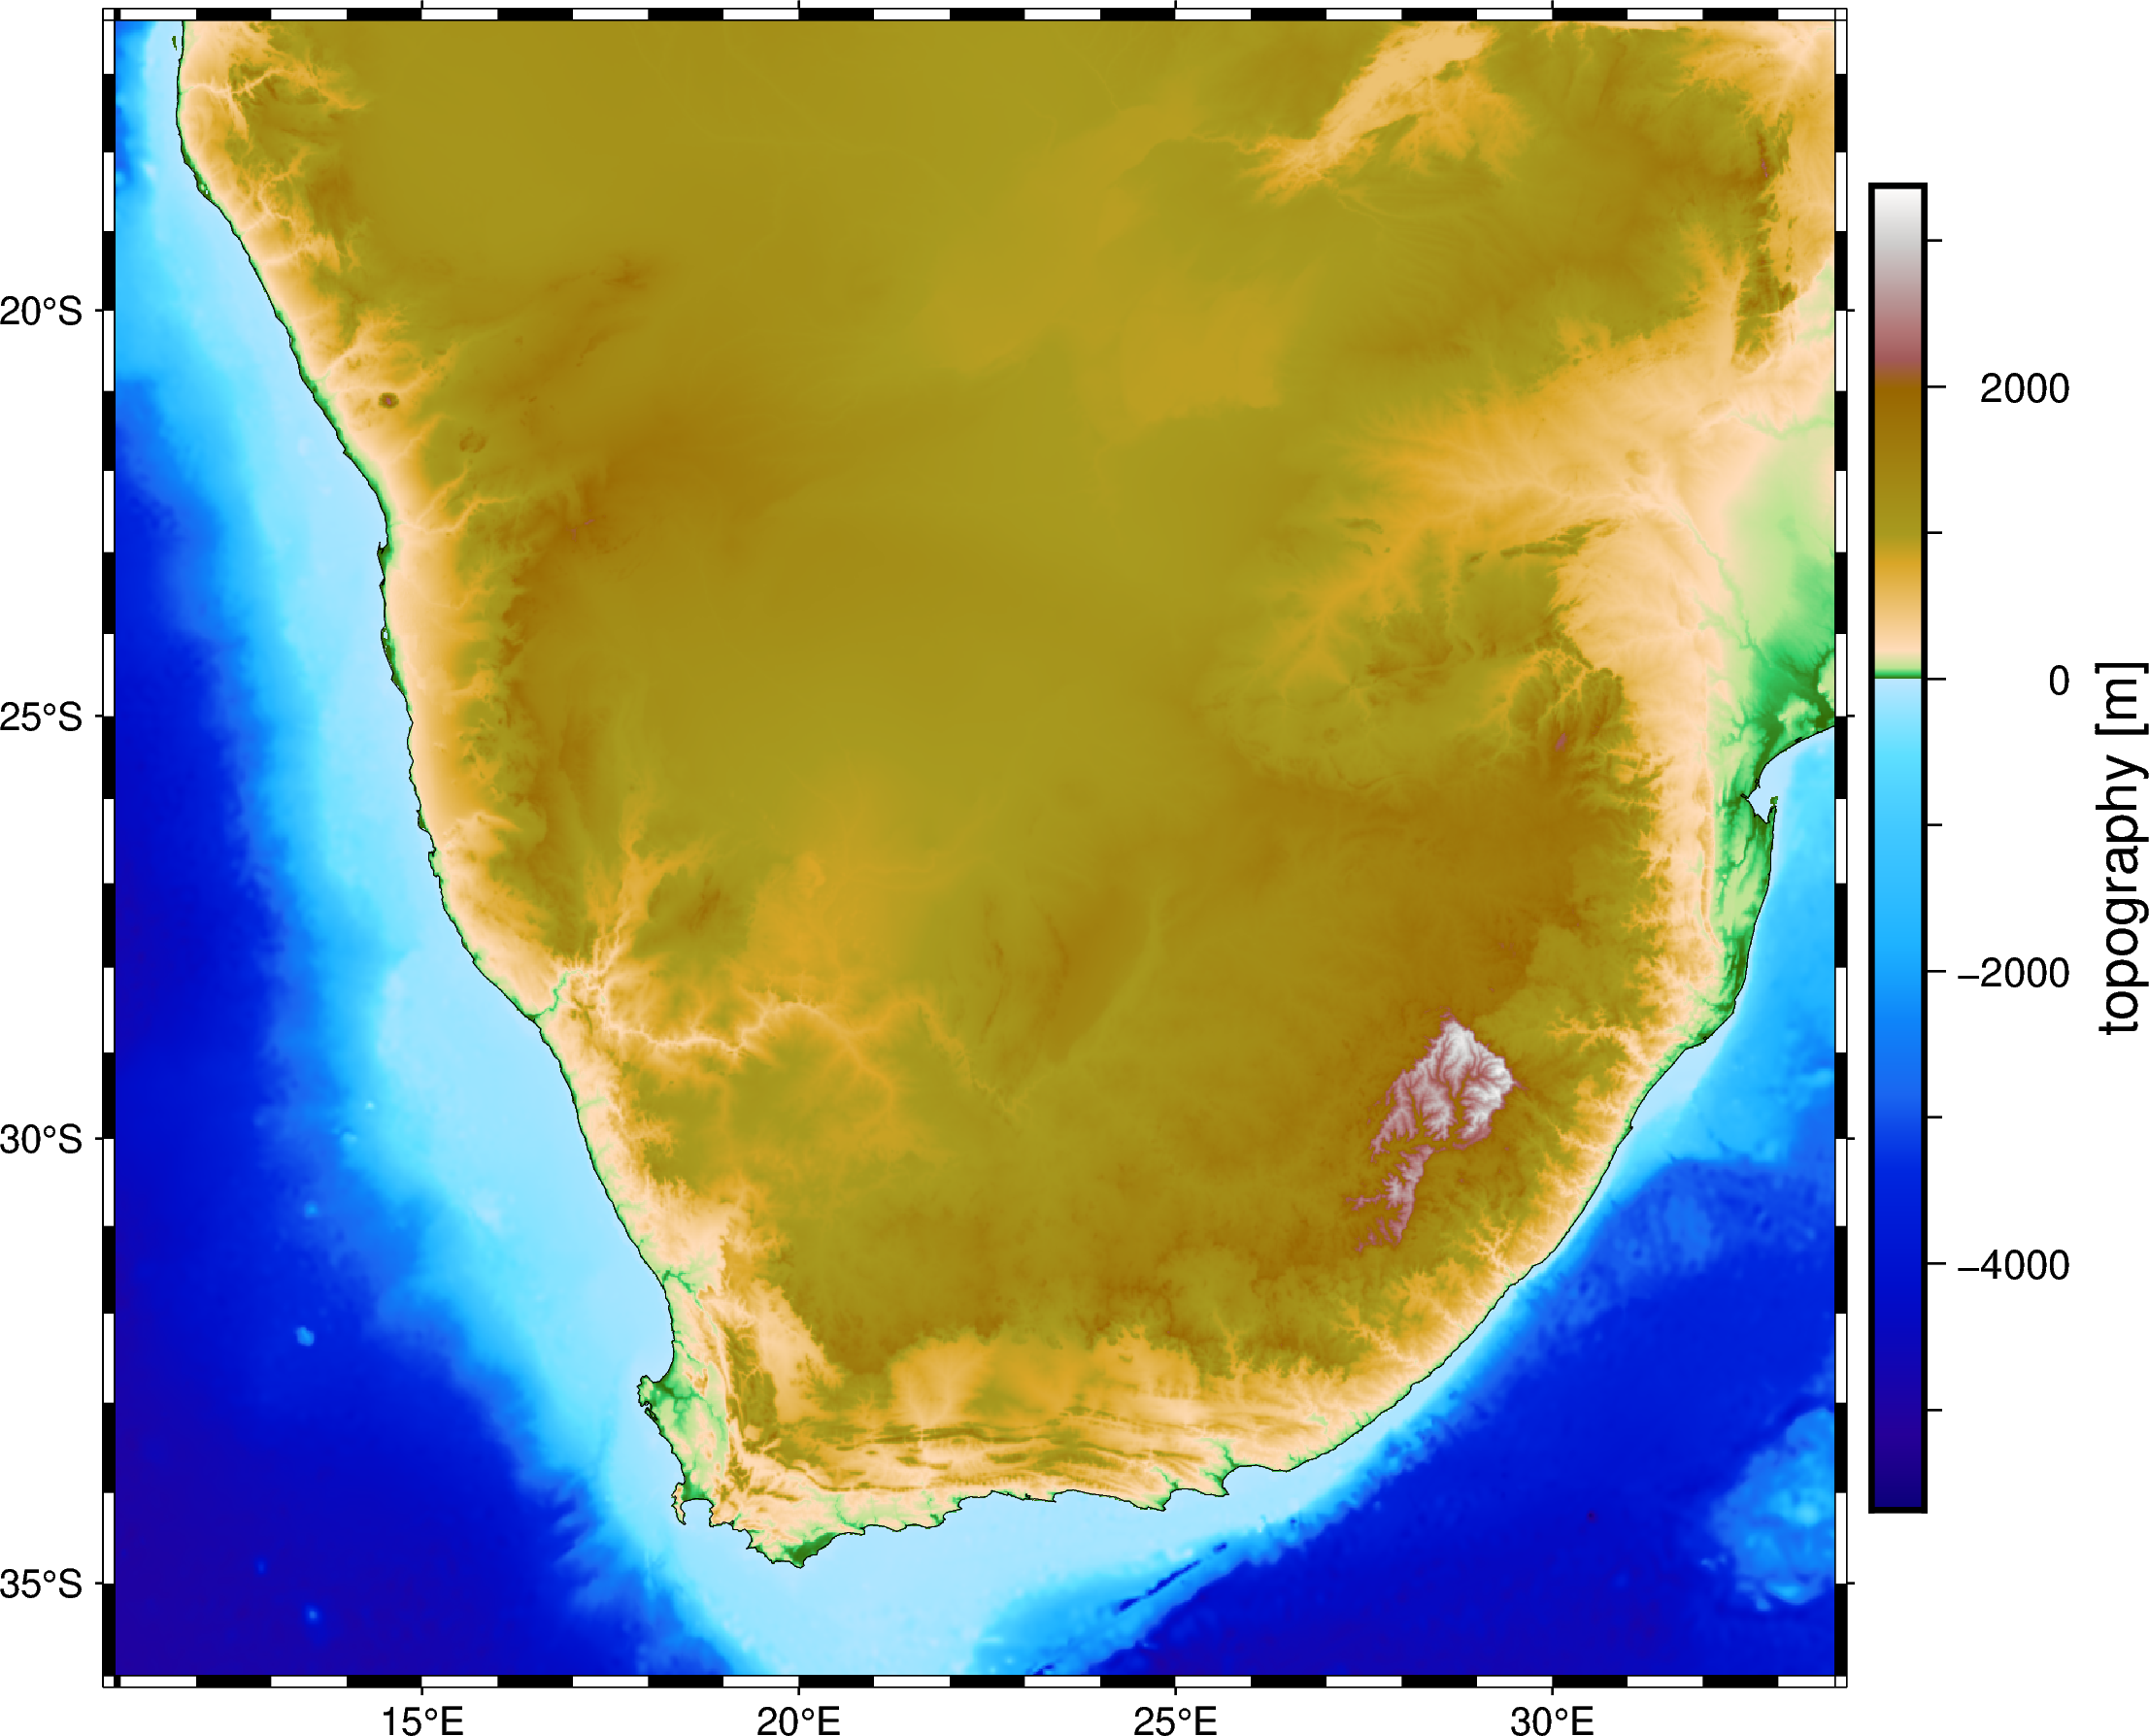

In [9]:
fig = pygmt.Figure()
fig.grdimage(data, cmap="etopo1", projection="M15c")
fig.colorbar(frame='af+l"topography [m]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)
fig.savefig("preview.jpg", dpi=200)
fig.show()

## Export

Save the grid to a netCDF file and calculate the size and MD5/SHA256 hashes.

Use compression (both zlib and discretization based) to reduce the file sizes. The scale_factor determines the amount of decimal places retained when converting floats into integers. See http://xarray.pydata.org/en/stable/user-guide/io.html#writing-encoded-datadata_reloaded

In [10]:
output = "southern-africa-topography.nc"
data.to_netcdf(
    output, 
    format="NETCDF4",
    encoding={
        'topography': {
            "zlib": True, 
            'dtype': 'int16', 
            'scale_factor': 1, 
            '_FillValue': 32000, 
            'add_offset': 0,
        },
    }
)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: southern-africa-topography.nc
size: 1.701373 Mb
md5:609d14fe4e551c5dcf320cdceedd30e8
sha256:3e3878a4bdf5e2e71cb85bab9d97e4e9733caf7ab5f74c0d799154fad1b41bef


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [11]:
data_reloaded = xr.load_dataarray(output)
data_reloaded

<xarray.DataArray 'topography' (latitude: 1182, longitude: 1371)>
array([[-5039., -5027., -5014., ..., -3846., -3867., -3873.],
       [-5036., -5021., -5007., ..., -3839., -3863., -3872.],
       [-5031., -5016., -5001., ..., -3835., -3860., -3870.],
       ...,
       [-2906., -2901., -2884., ...,   173.,   134.,   118.],
       [-2908., -2906., -2888., ...,   132.,   119.,   118.],
       [-2912., -2910., -2894., ...,   122.,   120.,   128.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 10.92 10.93 10.95 10.97 ... 33.72 33.73 33.75
  * latitude   (latitude) float64 -36.0 -35.98 -35.97 ... -16.35 -16.33 -16.32
Attributes:
    Conventions:    CF-1.8
    title:          Topographic and bathymetric height for Southern Africa ob...
    crs:            WGS84
    source:         Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/g...
    license:        public domain
    references:     https://doi.org/10.7289/V5C8276M
    long_name:      topographic height above mean sea level
    standard_name:  height_above_mean_sea_level
    description:    height topography/bathymetry referenced to mean sea level
    units:          m
    actual_range:   [-5685.  3376.]
    noaa_metadata:  Conventions: COARDS/CF-1.0\ntitle: ETOPO1_Ice_g_gmt4.grd\...

Check if the reloaded data is the same as the original one

In [12]:
assert np.allclose(data.longitude.values, data_reloaded.longitude.values)
assert np.allclose(data.latitude.values, data_reloaded.latitude.values)
assert np.allclose(data.values, data_reloaded.values)

Make the figure again but don't save it to a file this time.

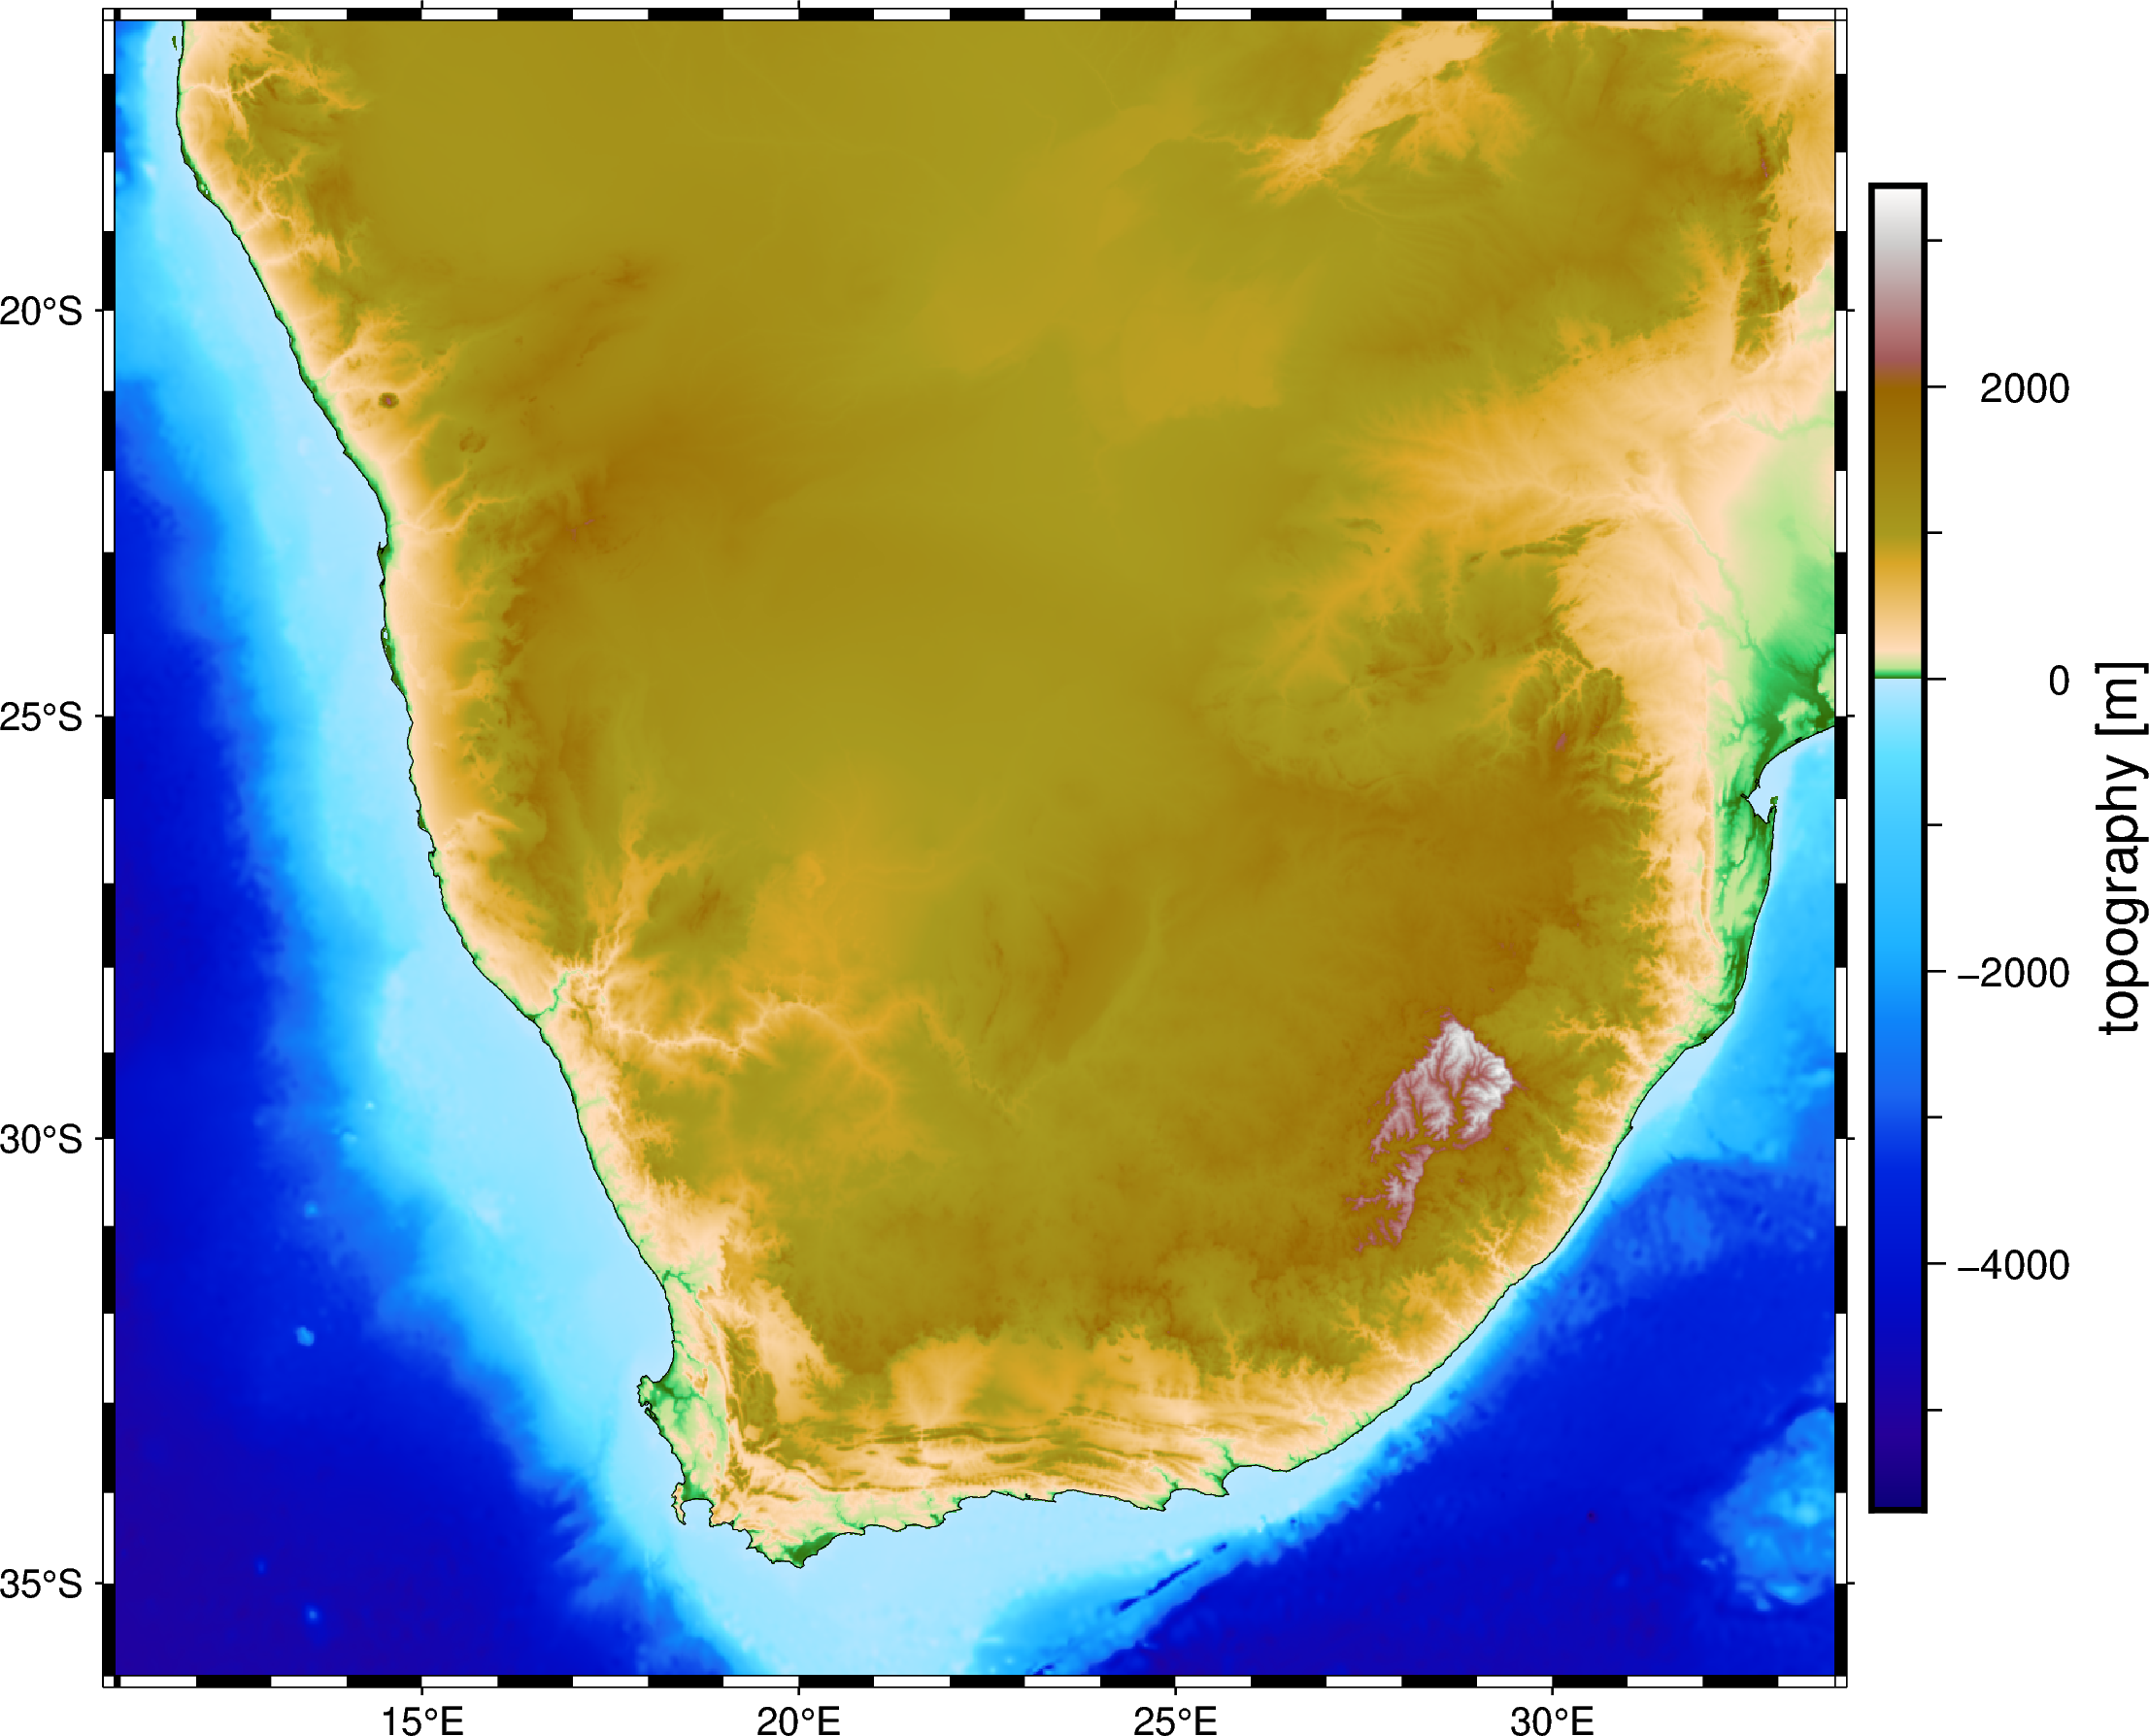

In [ ]:
fig = pygmt.Figure()
fig.grdimage(data_reloaded, cmap="etopo1", projection="M15c")
fig.colorbar(frame='af+l"topography [m]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)
fig.show()